# Microscope series SMFI viewer
Ben Jones 2024 (ben.jones@uta.edu)

In [2]:

#SMFI Microscope Control GUI
#Ben Jones 2022 (ben.jones@uta.edu)


import sys
import PyQt5
from PyQt5 import QtGui
from PyQt5.QtWidgets import  QApplication, QWidget, QPushButton, QFileDialog, QVBoxLayout, QMessageBox, QLineEdit, QFormLayout,QLabel, QGridLayout, QCheckBox, QSlider, QComboBox
from PyQt5.QtCore import Qt, QTimer, QObject, QThread, pyqtSignal
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg
import scipy.stats as stats
from time import time, sleep
from scipy import optimize
from scipy.interpolate import interp2d
import lzma
from Image import *


class MicroViewer:

    # ===============
    # Internal variables
    # ===============
    colormap= 'viridis'    # Color map for images

    CurrentImage=np.array([[0,0],[0,0]])   # The most recent image

    NoOfImages=100
    
    FillLength=3
    
    HiC = 30000
    LoC = 1000

    SeqSettings = None
    Seq = None
    ConfCut = 3
    MaxSpotsPerImage=100
    ShowingImage=1
    PlotFImage=False

    ShowingSpot=0
    
    PixHistBins=50
    GifDur=250  # speed of output gif
    GifDPI=150  # resolution of output gif
    CurrentImage=[[],[]]
    TotalTimeSeries=[]
    
    SpotsDict={'Heights':[],
          'Times':[],
          'Confs':[],
          'Traces':[],
          'X':[],
          'Y':[],
          'IntegralBefore':[],
          'IntegralAfter':[],
          'Integral':[]}

    # Camera thread calls back to this to update image and photo panel
    def updateimage(self):
        if(self.Seq==None):
            return
        if(self.PlotFImage):
            self.CurrentImage=self.Seq.Images[self.ShowingImage].FImage
        else:
            self.CurrentImage=self.Seq.Images[self.ShowingImage].Image
        self.LastSnapTime=time()
        self.ax_photo.clear()
        self.ax_photo.imshow(self.CurrentImage,cmap=self.colormap,vmin=self.LoC,vmax=self.HiC)
        self.ax_photo.set_xticks([])
        self.ax_photo.set_yticks([])

        if(bool(self.SpotCheck.isChecked())):
            SpotX=self.SpotsDict['X'][self.ShowingSpot]
            SpotY=self.SpotsDict['Y'][self.ShowingSpot]
            self.ax_photo.scatter(SpotX,SpotY,facecolors='none', edgecolors='r',s=30)
            self.ax_photo.text(SpotX+5,SpotY-5,str(self.ShowingSpot),color='red')
        self.CanvasPhoto.draw()
        
        self.UpdateTimeDistPlot()
        self.UpdateSpotPlot()
        self.UpdatePixIntensityPlot()

    # =======================
    #    Image handling
    # =======================

    def OpenSequenceFromPath(self,path):
        filenames=[]
        for j in range(0,self.NoOfImages):
            filenames.append(path+"/im_"+str(j).zfill(self.FillLength)+".txt")
        self.SeqSettings=SequenceSettings()
        self.SeqSettings.imtype='txt'
        self.SeqSettings.TopN=self.MaxSpotsPerImage
        self.Seq=Sequence(filenames,self.SeqSettings)
        self.TotalTimeSeries=[]
        for im in self.Seq.Images:
            self.TotalTimeSeries.append(sum(sum(im.Image)))
        self.FindSpots()
        self.UpdateTimeDistPlot()

    def UpdatePixIntensityPlot(self):
        self.ax_PixIntensity.clear()
        self.ax_PixIntensity.hist(np.log10(self.CurrentImage.flatten()),bins=np.linspace(np.log10(self.LoC),np.log10(self.HiC),self.PixHistBins))
        self.ax_PixIntensity.set_xlabel("Log[Pixel Intensity]")
        self.CanvasObj2.draw()

        
    def UpdateTimeDistPlot(self):
        self.ax_TimeDist.clear()
        self.ax_TimeDist.plot(self.TotalTimeSeries)
        self.ax_TimeDist.set_xlabel("Time")
        self.ax_TimeDist.set_ylabel("Total Intensity")
        self.ax_TimeDist.set_ylim(np.min(self.TotalTimeSeries),np.max(self.TotalTimeSeries))
        self.ax_TimeDist.plot([self.ShowingImage,self.ShowingImage], [np.min(self.TotalTimeSeries),np.max(self.TotalTimeSeries)],color='DarkGreen')
        self.CanvasObj.draw()

    def FindSpots(self,outfile=None):
        self.SpotsDict={'Heights':[],
          'Times':[],
          'Confs':[],
          'Traces':[],
          'X':[],
          'Y':[],
          'IntegralBefore':[],
          'IntegralAfter':[],
          'Integral':[]}
        
        for spot in range(0,self.MaxSpotsPerImage):
            TimeSeq=self.Seq.GetTimeSeq(spot)
            Locs,StepHeight,StepConfidence=self.Seq.StepMetric(TimeSeq)
    
            if(sum(np.array(StepConfidence)>self.ConfCut)>0):
                s=np.argmax(StepConfidence)
                plt.plot([Locs[s],Locs[s]],[0,np.max(TimeSeq)*1.1],color='red')
                self.SpotsDict['Times'].append(Locs[s])
                self.SpotsDict['Heights'].append(StepHeight[s])
                self.SpotsDict['Confs'].append(StepConfidence[s])
                self.SpotsDict['Traces'].append(TimeSeq)
                self.SpotsDict['X'].append(self.Seq.Found[spot,0])
                self.SpotsDict['Y'].append(self.Seq.Found[spot,1])
                self.SpotsDict['IntegralBefore'].append(sum(TimeSeq[0:s]))
                self.SpotsDict['IntegralAfter'].append(sum(TimeSeq[s:]))  
                self.SpotsDict['Integral'].append(sum(TimeSeq))
        if(outfile!=None):
            f=open(outfile,'wb')
            pickle.dump(SpotsDict,f)
            f.close()



    # =======================
    #   pyQT Widget functions
    # =======================

    def on_textbox_edit(self):
        self.NoOfImages=int(self.LoadHowMany.text())

    def on_tslider_move(self,value):
        self.ShowingImage=value
        self.updateimage()
        #print("jumping to image number "+ str(self.ShowingImage))


    # on photo panel, right click to save
    def on_photo_press(self, event):
        print("This happens when you click the image")


    # pick a path to load from
    def on_choose_folder(self):
        dlg = QFileDialog()
        dlg.setFileMode(QFileDialog.Directory)

        if dlg.exec_():
            filenames = dlg.selectedFiles()
        self.LoadPath.setText(filenames[0])
        self.OpenSequenceFromPath(filenames[0]+"/")
        print("opening sequence at "+filenames[0]+"/")
        self.updateimage()
        self.SpotSlide.setRange(0, len(self.SpotsDict['Traces']))                
        self.SpotSlide.setValue(0)


    def on_spotslider_move(self,value):
        self.ShowingSpot=value
        self.updateimage()
    
    def UpdateSpotPlot(self):
        self.ax_Spot.clear()
        Trace=self.SpotsDict['Traces'][self.ShowingSpot]
        self.ax_Spot.plot(Trace)
        self.ax_Spot.set_ylim(0.9*np.min(Trace),1.1*np.max(Trace))
        self.ax_Spot.plot([self.ShowingImage,self.ShowingImage], [np.min(Trace),np.max(Trace)],color='DarkGreen')
        self.ax_Spot.plot([self.SpotsDict['Times'][self.ShowingSpot],self.SpotsDict['Times'][self.ShowingSpot]], [0.9*np.min(Trace),1.1*np.max(Trace)],color='pink')
        self.SpotDetailsS.setText("spot :  "+str(self.ShowingSpot))
        self.SpotDetailsX.setText("X    :  "+str(self.SpotsDict['X'][self.ShowingSpot]))
        self.SpotDetailsY.setText("Y    :  "+str(self.SpotsDict['Y'][self.ShowingSpot]))
        self.SpotDetailsH.setText("Ht   :  "+str(np.round(self.SpotsDict['Heights'][self.ShowingSpot],0)))
        self.SpotDetailsC.setText("Conf :  "+str(np.round(self.SpotsDict['Confs'][self.ShowingSpot],1)))
        self.CanvasObjSpot.draw()

    
    
    # ====================
    #  PyQt GUI Frames
    # ====================

    def ExportSpots(self):
        dlg = QFileDialog()
        dlg.setFileMode(QFileDialog.AnyFile)
        dlg.setAcceptMode(QFileDialog.AcceptSave)

        if dlg.exec_():
            filenames = dlg.selectedFiles()
        SpotsPath=filenames[0]
        self.FindSpots(self,outfile=SpotsPath)
    
    def ExportGif(self):
        dlg = QFileDialog()
        dlg.setFileMode(QFileDialog.AnyFile)
        dlg.setAcceptMode(QFileDialog.AcceptSave)

        if dlg.exec_():
            filenames = dlg.selectedFiles()
        GifPath=filenames[0]
        
        self.Seq.MakeGif(GifPath,Filtered=self.PlotFImage,vmin=self.LoC, vmax=self.HiC,cmap=self.colormap,dpi=self.GifDPI,dur=self.GifDur)
        

    def SetupPhotoFrame(self):
        self.PhotoLayout=QGridLayout()


        self.photo= plt.figure(figsize=(5,5),dpi=200)
        self.photo.add_axes(rect=[0,0,1,1])
        self.ax_photo=self.photo.get_axes()[0]
        self.CanvasPhoto=FigureCanvasQTAgg(self.photo)

        self.TSlide=QSlider(orientation=Qt.Horizontal)
        self.TSlide.setRange(0, self.NoOfImages-1)
        self.TSlide.setValue(0)

        
        self.LoadDir=QPushButton("Pick folder")
        self.LoadHowMany=QLineEdit("100")

        self.LoadPath=QLineEdit("./imgs/")

        self.LoadDir.clicked.connect(self.on_choose_folder)

        self.CanvasPhoto.mpl_connect("button_press_event", self.on_photo_press)
        self.PhotoLayout.addWidget(self.CanvasPhoto,1,0,8,4)

        self.TSlide.sliderMoved.connect(self.on_tslider_move)
        self.PhotoLayout.addWidget(self.TSlide, 9,0,1,4)
        
        self.PhotoLayout.addWidget(self.LoadPath,11,2,1,1)
        self.PhotoLayout.addWidget(self.LoadHowMany,11,3,1,1)
        self.PhotoLayout.addWidget(self.LoadDir,12,1,1,4)


    def UpdateSettings(self):
        self.HiC=int(self.CHiText.text())
        self.LoC=int(self.CLoText.text())
        self.PlotFImage=bool(self.FImageCheck.isChecked())
        self.colormap=str(self.ColorMapText.currentText())
        self.updateimage()

    def SetupSettingsFrame(self):
        
        self.SettingsLayout = QGridLayout()

        self.CLoText=QLineEdit(text=str(self.LoC))
        self.CHiText=QLineEdit(text=str(self.HiC))
        self.ColorMapText=  QComboBox()
        self.ColorMapText.addItem('viridis')
        self.ColorMapText.addItem('afmhot')
        self.ColorMapText.addItem('jet')
        self.ColorMapText.addItem('ocean')

        self.FImageCheck=QCheckBox("Filtered?")
        self.ExportGifButton=QPushButton("Export Gif")
        self.ExportSpotsButton=QPushButton("Export Spots")

        self.CLoText.textChanged.connect(self.UpdateSettings)
        self.CHiText.textChanged.connect(self.UpdateSettings)
        self.FImageCheck.clicked.connect(self.UpdateSettings)
        self.ColorMapText.currentTextChanged.connect(self.UpdateSettings)
        self.ExportGifButton.clicked.connect(self.ExportGif)
        self.ExportSpotsButton.clicked.connect(self.ExportSpots)
                                 
        #self.CSlideMax=QSlider(orientation=Qt.Vertical)
        #self.CSlideMax.setRange(0, 25555)
        
        #self.CSlideMin=QSlider(orientation=Qt.Vertical)
        #self.CSlideMin.setRange(0, 25555)

        self.SettingsLayout.addWidget(QLabel("Settings"),0,0,2,1)
        self.SettingsLayout.addWidget(QLabel("Color Limits"),1,0,2,1)
        self.SettingsLayout.addWidget(self.CLoText,2,0,1,1)
        self.SettingsLayout.addWidget(self.CHiText,2,1,1,1)
        self.SettingsLayout.addWidget(QLabel("Color Map"),3,0,2,1)
        self.SettingsLayout.addWidget(self.ColorMapText,4,0,2,2)
        self.SettingsLayout.addWidget(self.FImageCheck,6,0,2,1)
        self.SettingsLayout.addWidget(self.ExportGifButton,8,0,2,1)
        self.SettingsLayout.addWidget(self.ExportSpotsButton,8,1,2,1)


        #self.PhotoLayout.addWidget(self.CSlideMin,1,5,11,1)
        #self.PhotoLayout.addWidget(self.CSlideMax,1,6,11,1)


    def SetupCanvasFrame(self):
        
        self.FigLayout=QVBoxLayout()
        self.fig= plt.figure(figsize=(8,5),dpi=100)
        self.fig.add_axes(rect=[0.15,0.15,0.8,0.8])
        self.fig2= plt.figure(figsize=(8,5),dpi=100)
        self.fig2.add_axes(rect=[0.15,0.15,0.8,0.8])

        self.ax_TimeDist=self.fig.get_axes()[0]
        self.ax_PixIntensity = self.fig2.get_axes()[0]

        self.CanvasObj=FigureCanvasQTAgg(self.fig)
        self.CanvasObj2=FigureCanvasQTAgg(self.fig2)
        #self.MakePosPlots()

        #self.CanvasObj.mpl_connect("button_release_event", self.on_map_press)
        #self.CanvasObj2.mpl_connect("button_press_event", self.on_zplot_press)
        #self.CanvasObj2.mpl_connect("button_release_event", self.on_zplot_release)
        self.FigLayout.addWidget(QLabel("Overall Time Series"))
        self.FigLayout.addWidget(self.CanvasObj)
        self.FigLayout.addWidget(QLabel("Pixel Intensities"))
        self.FigLayout.addWidget(self.CanvasObj2)


    
    def SetupSpotsFrame(self):
        self.SpotLayout=QVBoxLayout()
        self.figspot= plt.figure(figsize=(5,5),dpi=100)
        self.figspot.add_axes(rect=[0.15,0.15,0.8,0.8])
        
        self.ax_Spot=self.figspot.get_axes()[0]
        self.CanvasObjSpot=FigureCanvasQTAgg(self.figspot)
        self.SpotSlide=QSlider(orientation=Qt.Horizontal)
        self.SpotSlide.setRange(0, np.maximum(len(self.SpotsDict['Traces']),1))                
        self.SpotDetailsS=QLabel("spot :  ")
        self.SpotDetailsX=QLabel("X    :  ")
        self.SpotDetailsY=QLabel("Y    :  ")
        self.SpotDetailsH=QLabel("Ht   :  ")
        self.SpotDetailsC=QLabel("Conf :  ")
        self.SpotCheck=QCheckBox("Show Spot?")    
        self.SpotLayout.addWidget(QLabel("Spot Inspector"))
        self.SpotLayout.addWidget(self.CanvasObjSpot)
        self.SpotLayout.addWidget(self.SpotSlide)
        self.SpotLayout.addWidget(self.SpotDetailsS)
        self.SpotLayout.addWidget(self.SpotDetailsX)
        self.SpotLayout.addWidget(self.SpotDetailsY)
        self.SpotLayout.addWidget(self.SpotDetailsH)
        self.SpotLayout.addWidget(self.SpotDetailsC)
        self.SpotLayout.addWidget(self.SpotCheck)

        
        
        self.SpotSlide.sliderMoved.connect(self.on_spotslider_move)
        self.SpotCheck.stateChanged.connect(self.updateimage)

    
    # ===================
    #  Initializer
    # ===================

    def __init__(self,HARDWARE_ON=False, COMPRESSION_ON=True, StageIn=None, CamHamPyIn=None):

        # PyQt setup stuff
        self.app = QApplication([])
        self.window = QWidget()
        self.layout= QGridLayout()

        # Initiate all the GUI frames and make the layout
        #self.SetupMoveFrame()
        #self.SetupCamSettingsFrame()
        self.SetupCanvasFrame()
        self.SetupSpotsFrame()
        self.SetupSettingsFrame()
        self.SetupPhotoFrame()

        #self.layout.addLayout(self.MoveLayout,1,0)
        #self.layout.addLayout(self.CamLayout,2,0)
        
        self.layout.addLayout(self.FigLayout,0,0,2,1)
        self.layout.addLayout(self.PhotoLayout,0,1,2,1)
        self.layout.addLayout(self.SpotLayout,0,2,1,1)
        self.layout.addLayout(self.SettingsLayout,1,2,1,1)
        self.layout.setColumnMinimumWidth(0,300)
        self.layout.setColumnMinimumWidth(1,500)
        self.layout.setColumnMinimumWidth(2,300)
        self.layout.setRowMinimumHeight(0,300)
        self.layout.setRowMinimumHeight(1,300)
    
        self.window.setLayout(self.layout)
        self.window.show()
        self.app.exec()



2024-08-25 14:11:58.887 python[78217:11968069] +[CATransaction synchronize] called within transaction


opening sequence at /Users/ben.jones/Documents/Data/08_24_PressureScope/Air/4/


2024-08-25 14:12:13.153 python[78217:11968069] IMKClient Stall detected, *please Report* your user scenario attaching a spindump (or sysdiagnose) that captures the problem - (imkxpc_bundleIdentifierWithReply:) block performed very slowly (7.86 secs).


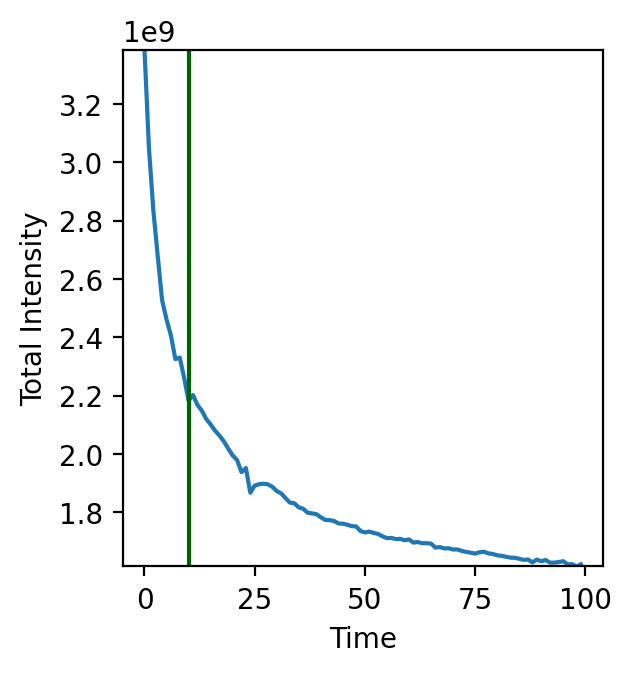

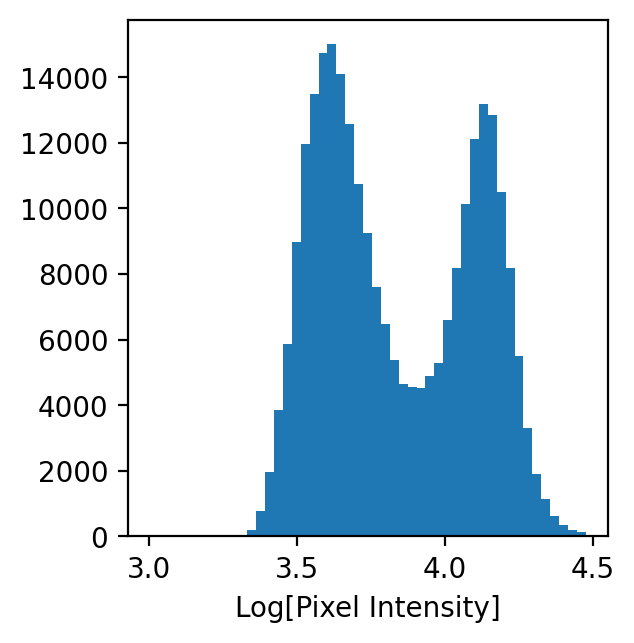

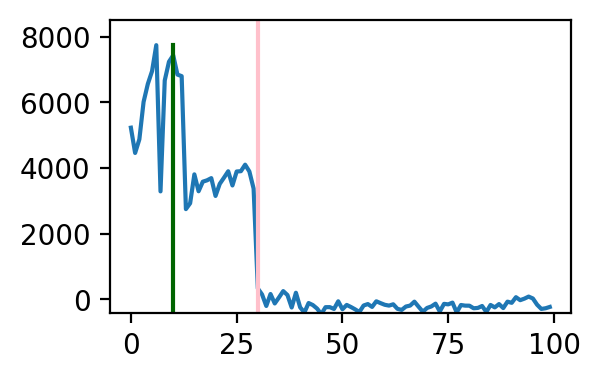

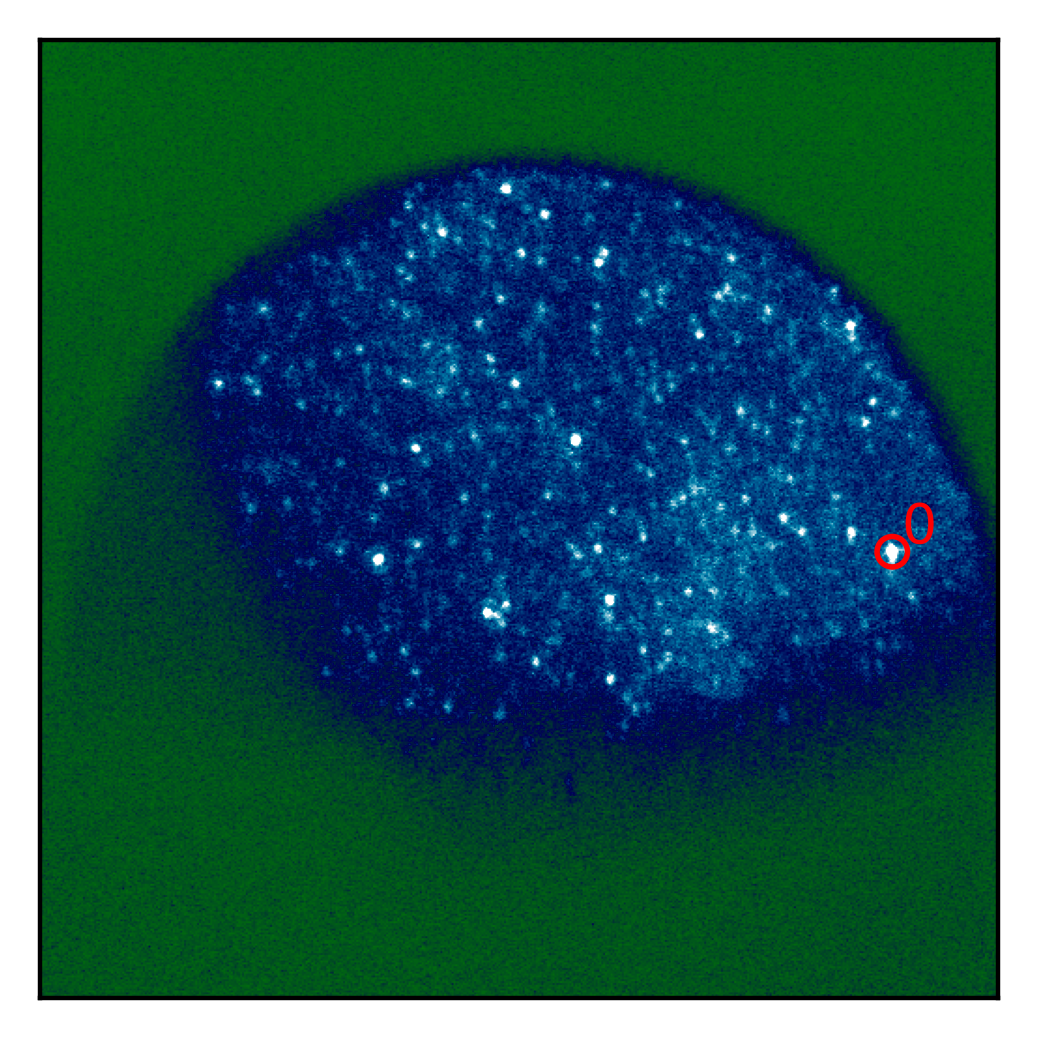

In [3]:
MicroViewer()

In [ ]:
self.PhotoLayout.addWidget?

In [ ]:
    def on_textbox_edit(self):
        self.MoveTo(float(self.XText.text()),
                    float(self.YText.text()),
                    float(self.ZText.text()))

    def on_custom_click(self):
        if(self.AmCustomAction==False):
            self.XOrigin=self.X
            self.YOrigin=self.Y
            self.ZOrigin=self.Z
            self.AmCustomAction=True
            self.NextStageAction=self.CustomAction
            self.ActionNo=0
        else:
            self.AmCustomAction=False
            self.NextStageAction=self.NullStageAction                         

        
    def on_zsweep_click(self):
        if(self.AmZSweeping==False):
            self.ClearZHistory()
            self.MoveTo(self.X,self.Y,float(self.ZSweepMin.text()))
            self.NextStageAction=self.ZSweepStageAction
            self.FS.ZSweepMin=float(self.ZSweepMin.text())
            self.FS.ZSweepMax=float(self.ZSweepMax.text())
            self.FS.ZSweepSteps=float(self.ZSweepSteps.text())
            self.ZSweep.setText("Stop ZSweep")
            self.AmZSweeping=True
        else:
            self.NextStageAction=self.NullStageAction
            self.ZSweep.setText("Start ZSweep")
            self.AmZSweeping=False

    #Any camera setting change triggers this
    def on_cam_settings_change(self):
        self.camdict['CS'].EMCCD=self.CamEMCCD.isChecked()
        #try:
        if(self.camdict['CS'].EMCCD==True):
            if(int(self.CamExposure.text())<27):
                self.camdict['CS'].Exposure=27
            elif(int(self.CamExposure.text())>10000):
                self.camdict['CS'].Exposure=10000
            else:
                try:
                    self.camdict['CS'].Exposure=int(self.CamExposure.text())
                except:
                    self.camdict['CS'].Exposure=500
        elif(self.camdict['CS'].EMCCD==False):
            if(int(self.CamExposure.text())<500):
                self.camdict['CS'].Exposure=500
            elif(int(self.CamExposure.text())>10000):
                self.camdict['CS'].Exposure=10000
            else:
                self.camdict['CS'].Exposure=int(self.CamExposure.text())

        if(self.camdict['CS'].EMCCD==False):
            self.camdict['CS'].Gain=1
        else:
            if(int(self.CamGain.text())<1):
                self.camdict['CS'].Gain=1
            elif(int(self.CamGain.text())>255):
                self.camdict['CS'].Gain=255
            else:
                self.camdict['CS'].Gain=int(self.CamGain.text())

        self.CamExposure.setText(str(self.camdict['CS'].Exposure))
        self.CamGain.setText(str(self.camdict['CS'].Gain))

    # Switch servo / camera on and off
    def on_servo_change(self):
        if(self.ServosCheckBox.isChecked()==True):
            self.MyStage.EnableServos()
        elif(self.ServosCheckBox.isChecked()==False):
            self.MyStage.DisableServos()

    def on_camera_change(self):
        if(self.CameraCheckBox.isChecked()==True):
            self.EnableCamera()
        elif(self.CameraCheckBox.isChecked()==False):
            self.DisableCamera()

    # Autofocus buttons
    def on_autointensity(self):
        self.MoveTo(self.X,self.Y,self.ZBestIntensity)

    def on_autokurtosis(self):
        self.MoveTo(self.X,self.Y,self.ZBestKurtosis)

    # Start a sequence
    def on_sequence_go(self):
        if(self.Sequence.text()=="Go"):
            if(self.AmStreaming==False):
                self.on_stream_click()
            self.ImagesToSave=int(self.StoreCount.text())
            self.NextCameraAction=self.SequenceCameraAction
            self.Sequence.setText("Stop")
        else:
            self.StoreCount.setText(str(self.ImagesToSave))
            self.NextCameraAction=self.NullCameraAction
            self.Sequence.setText("Go")

    # Clear the focal point array
    def on_focusclear(self):
        self.HisT.Focus={}
        self.UpdateAll()

    #Move to extrapolated focal point
    def on_focusextrap(self):
        self.MoveTo(self.X,self.Y,self.FocalPlane(self.X,self.Y))

    #Add a focal point
    def on_focushere(self):
        self.HisT.Focus[len(self.HisT.X)-1]=self.Z

        #If there are at least 3 points, extrapolate a focal plane
        if(len(list(self.HisT.Focus.keys()))>2):
            FocXs=np.array(self.HisT.X)[list(self.HisT.Focus.keys())]
            FocYs=np.array(self.HisT.Y)[list(self.HisT.Focus.keys())]
            FocZs=list(self.HisT.Focus.values())
            self.DefineFocalPlane(FocXs,FocYs,FocZs)
        self.UpdateAll()

    # If user clicks the XY map, go there.
    #  If we have a focal plane use it, otherwise stick at this Z.
    def on_map_press(self,event):
        if(self.FocalPlane!=None):
            self.MoveTo(event.xdata,event.ydata,self.FocalPlane(event.xdata,event.ydata))
        else:
            self.MoveTo(event.xdata,event.ydata,self.Z)


    # On Z plot, click + drag to zoom in, rclk to reset
    def on_zplot_press(self, event):
        self.Z1=round(event.xdata,self.precision)

    def on_zplot_release(self, event):
        if(event.button==2):
            self.Z2=round(event.xdata,self.precision)
            self.FS.ZMin=min(self.Z1,self.Z2)
            self.FS.ZMax=max(self.Z1,self.Z2)
            self.ZSweepMin.setText(str(self.FS.ZMin))
            self.ZSweepMax.setText(str(self.FS.ZMax))
        elif(event.button==1):
            self.MoveTo(self.X,self.Y,round(event.xdata,self.precision))


In [ ]:


    def SetupCamSettingsFrame(self):
        self.CamLayout= QFormLayout()
        self.CamLayout.addRow(QLabel("Camera Settings:"),QLabel(" "))
        self.CamGain=QLineEdit(text=str(self.camdict['CS'].Gain))
        self.CamExposure=QLineEdit(text=str(self.camdict['CS'].Exposure))
        self.CamEMCCD=QCheckBox()

        self.CamLayout.addRow(QLabel("Gain:"),self.CamGain)
        self.CamLayout.addRow(QLabel("Exposure:"),self.CamExposure)
        self.CamLayout.addRow(QLabel("EMCCD:"),self.CamEMCCD)

        self.CamGain.editingFinished.connect(self.on_cam_settings_change)
        self.CamExposure.editingFinished.connect(self.on_cam_settings_change)
        self.CamEMCCD.stateChanged.connect(self.on_cam_settings_change)


    def SetupActionsFrame(self):
        self.ActionsLayout= QGridLayout()
        self.ActionsLayout.addWidget(QLabel("Enable:"),1,0,1,3)


        self.ZSweep=QPushButton('Start ZSweep')
        self.ZSweep.clicked.connect(self.on_zsweep_click)
        
        self.Custom=QPushButton('Start Custom')
        self.Custom.clicked.connect(self.on_custom_click)
        
        self.ZSweepMin=QLineEdit(text=str(self.FS.ZSweepMin))
        self.ZSweepMax=QLineEdit(text=str(self.FS.ZSweepMax))
        self.ZSweepSteps=QLineEdit(text=str(self.FS.ZSweepSteps))

        self.ServosCheckBox=QCheckBox("Servos",checked=True)
        self.ServosCheckBox.stateChanged.connect(self.on_servo_change)

        self.CameraCheckBox=QCheckBox("Camera",checked=True)
        self.CameraCheckBox.stateChanged.connect(self.on_camera_change)

        self.AutoFocusKurtosis=QPushButton("Kurtosis")
        self.AutoFocusIntensity=QPushButton("Intensity")
        self.AutoFocusClear=QPushButton('Clear')
        self.AutoFocusKurtosis.clicked.connect(self.on_autokurtosis)
        self.AutoFocusIntensity.clicked.connect(self.on_autointensity)
        self.AutoFocusClear.clicked.connect(self.ClearZHistory)

        self.FocusHere=QPushButton('Record')
        self.FocusExtrap=QPushButton('Extrapolate')
        self.FocusClear=QPushButton('Clear')
        self.FocusHere.clicked.connect(self.on_focushere)
        self.FocusExtrap.clicked.connect(self.on_focusextrap)
        self.FocusClear.clicked.connect(self.on_focusclear)

        self.ActionsLayout.addWidget(self.ServosCheckBox,2,0,1,2)
        self.ActionsLayout.addWidget(self.CameraCheckBox,2,1,1,2)
        
        self.ActionsLayout.addWidget(QLabel("Custom Action:"),4,0,1,1)
        self.ActionsLayout.addWidget(self.Custom,5,0,1,2)

        self.ActionsLayout.addWidget(QLabel("ZSweep:"),6,0,1,1)
        self.ActionsLayout.addWidget(self.ZSweep,7,0,1,2)
        self.ActionsLayout.addWidget(self.ZSweepMin,8,0,1,1)
        self.ActionsLayout.addWidget(self.ZSweepMax,8,1,1,1)
        self.ActionsLayout.addWidget(self.ZSweepSteps,8,2,1,1)
        
        self.ActionsLayout.addWidget(QLabel("AutoFocus:"),10,0,1,3)
        self.ActionsLayout.addWidget(self.AutoFocusIntensity,11,0,1,1)
        self.ActionsLayout.addWidget(self.AutoFocusKurtosis,11,1,1,1)
        self.ActionsLayout.addWidget(self.AutoFocusClear,11,2,1,1)

        self.ActionsLayout.addWidget(QLabel("Focal Plane:"),13,0,1,3)
        self.ActionsLayout.addWidget(self.FocusHere,14,0,1,1)
        self.ActionsLayout.addWidget(self.FocusExtrap,14,1,1,1)
        self.ActionsLayout.addWidget(self.FocusClear,14,2,1,1)
